In [1]:
import skrf as rf # required for working with the .s2p files...
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import AutoMinorLocator
import csv, glob
import os
import re
from collections import defaultdict

In [2]:
%matplotlib widget

### May 30th

- Characterization of the EIGSEP front-end, consisting of the Amplifier, 3dB attenuator, low/high pass filters, and optical transmitter module.
- The overall setup consists of the front-end specified above, and the PAM receivers --
  port 1 FieldFox to LNA input, LNA output to remainder of front-end, optical transmitter output to PAM input, PAM output to port 2 FieldFox.

In [3]:
def load_s2p_manual(filename):
    freq = []
    S11 = []
    S21 = []
    S12 = []
    S22 = []
    with open(filename, 'r') as f:
        for line in f:
            if line.strip().startswith('!') or line.strip().startswith('#'):
                continue
            parts = line.strip().split()
            if len(parts) != 9:
                continue
            freq.append(float(parts[0]) / 1e6)  # Hz to MHz
            S11.append(complex(float(parts[1]), float(parts[2])))
            S21.append(complex(float(parts[3]), float(parts[4])))
            S12.append(complex(float(parts[5]), float(parts[6])))
            S22.append(complex(float(parts[7]), float(parts[8])))
    return {
        "frequency": np.array(freq),
        "S11": np.array(S11),
        "S21": np.array(S21),
        "S12": np.array(S12),
        "S22": np.array(S22),
    }

In [4]:
def plot_lines(x, y, x_label="X", y_label="Y", title=None, legend_title="Label", xlim=None, ylim=None, label=None):
    """
    Plots a single line or multiple lines from a dictionary of Y values against a shared X array.

    Parameters
    ----------
    x : array-like
        Shared X-axis data.
    y : array-like or dict
        Either a single Y array or a dictionary mapping labels to Y arrays.
    """

    sns.set_context("paper")
    sns.set_style("whitegrid")
    sns.set_palette("colorblind")

    fig, ax = plt.subplots(figsize=(12,4))

    if isinstance(y, dict):
        for lbl, y_array in sorted(y.items()):
            sns.lineplot(x=x, y=np.real(y_array), label=str(lbl), ax=ax, lw=1.2)
    else:
        sns.lineplot(x=x, y=np.real(y), label=label or "s-param", ax=ax, lw=1.2)

    ax.set_title(title, fontsize=12)
    ax.set_xlabel(x_label, fontsize=12)
    ax.set_ylabel(y_label, fontsize=12)

    if xlim:
        ax.set_xlim(*xlim)
    if ylim:
        ax.set_ylim(*ylim)

    ax.xaxis.set_minor_locator(AutoMinorLocator())
    ax.yaxis.set_minor_locator(AutoMinorLocator())

    ax.tick_params(axis='both', which='major', direction='in', length=6, width=1, bottom=True, left=True)
    ax.tick_params(axis='both', which='minor', direction='in', length=3, width=0.8, bottom=True, left=True)

    for spine in ax.spines.values():
        spine.set_linewidth(1.2)

    ax.grid(True, which='major', linestyle='--', linewidth=0.5, alpha=0.85)

    ax.legend(
        title=legend_title if isinstance(y, dict) else None,
        fontsize=11,
        title_fontsize=11,
        loc="upper right",
        ncol=3,
        borderaxespad=0,
        frameon=True
    )

    fig.tight_layout()
    plt.show()

In [5]:
data = load_s2p_manual("/Users/rs_mbpro14/RAL/RFoF/may30_eigsep_front_end_test/may30_eFEM_fatten3db_test.s2p")

In [6]:
s21 = data["S21"]
s11 = data["S11"]
s12 = data["S12"]
s22 = data["S22"]
freq = data["frequency"]

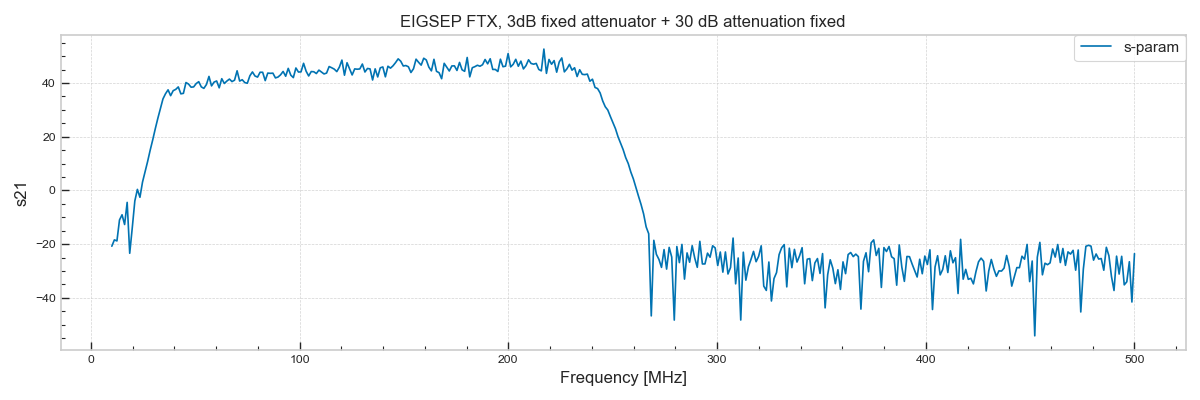

In [7]:
plot_lines(freq, s21, x_label="Frequency [MHz]", y_label="s21", title="EIGSEP FTX, 3dB fixed attenuator + 30 dB attenuation fixed")

In [8]:
def load_single_csv(filename):
    freqs = []
    power = []
    with open(filename, "r") as f:
        reader = csv.reader(f)
        begin_found = False
        for row in reader:
            if not row or row[0].startswith("!"):
                continue
            if row[0] == "BEGIN":
                begin_found = True
                continue
            if begin_found:
                try:
                    freqs.append(float(row[0]) / 1e6) 
                    power.append(float(row[1]))
                except (ValueError, IndexError):
                    continue
    return freqs, power

In [9]:
pwr_data = "/Users/rs_mbpro14/RAL/RFoF/may30_eigsep_front_end_test/may30_eFEM_-75dbm.csv"
frqs, pwr = load_single_csv(pwr_data)

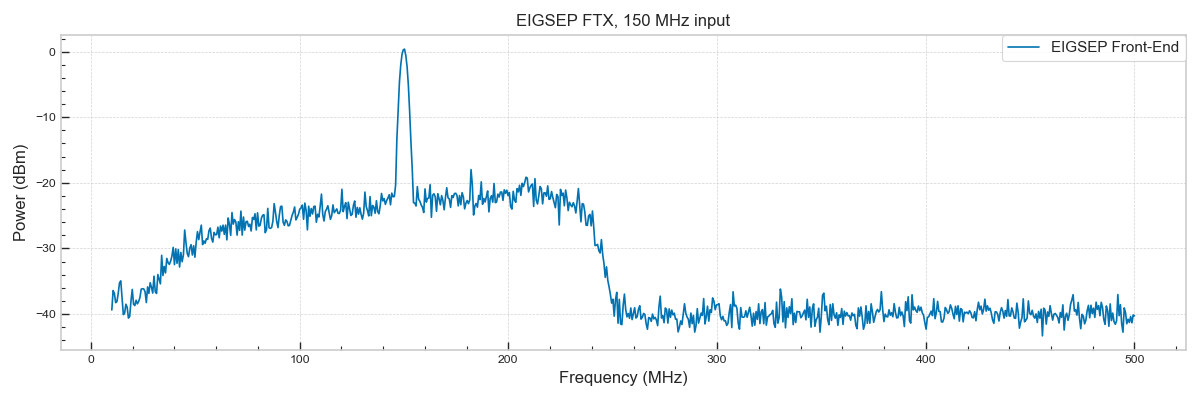

In [10]:
plot_lines(frqs, pwr, x_label='Frequency (MHz)', y_label='Power (dBm)', label="EIGSEP Front-End", title="EIGSEP FTX, 150 MHz input")

### June 6th EIGSEP FTX (front-end) Characterization

In [11]:
freq1,dat1=load_single_csv("/Users/rs_mbpro14/RAL/RFoF/june6_front_end_tests/AutoSave1.csv")
freq1,dat2=load_single_csv("/Users/rs_mbpro14/RAL/RFoF/june6_front_end_tests/AutoSave2.csv")
freq1,dat3=load_single_csv("/Users/rs_mbpro14/RAL/RFoF/june6_front_end_tests/AutoSave3.csv")
freq1,dat4=load_single_csv("/Users/rs_mbpro14/RAL/RFoF/june6_front_end_tests/AutoSave4.csv")

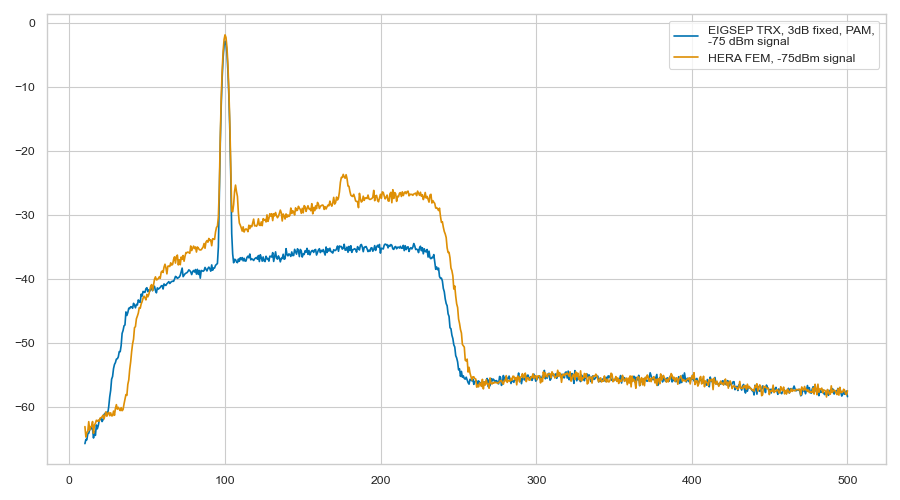

In [12]:
plt.figure(figsize=(9,5))
# plt.plot(freq1, dat1, label="HERA FEM")
plt.plot(freq1, dat2, label="EIGSEP TRX, 3dB fixed, PAM,\n-75 dBm signal")
plt.plot(freq1, dat3, label="HERA FEM, -75dBm signal")
plt.legend()
plt.tight_layout()
plt.show()

In [30]:
# ======== EIGSEP TRX ===========
dat5 = load_s2p_manual("/Users/rs_mbpro14/RAL/RFoF/june6_front_end_tests/AutoSave8.s2p")
s_21 = dat5["S21"]
s_11 = dat5["S11"]
s_12 = dat5["S12"]
s_22 = dat5["S22"]
freq_ = dat5["frequency"]

# ======== HERA FEM ==========
dat6 = load_s2p_manual("/Users/rs_mbpro14/RAL/RFoF/june6_front_end_tests/AutoSave9.s2p")
s__21 = dat6["S21"]
s__11 = dat6["S11"]
s__12 = dat6["S12"]
s__22 = dat6["S22"]
freq__ = dat6["frequency"]

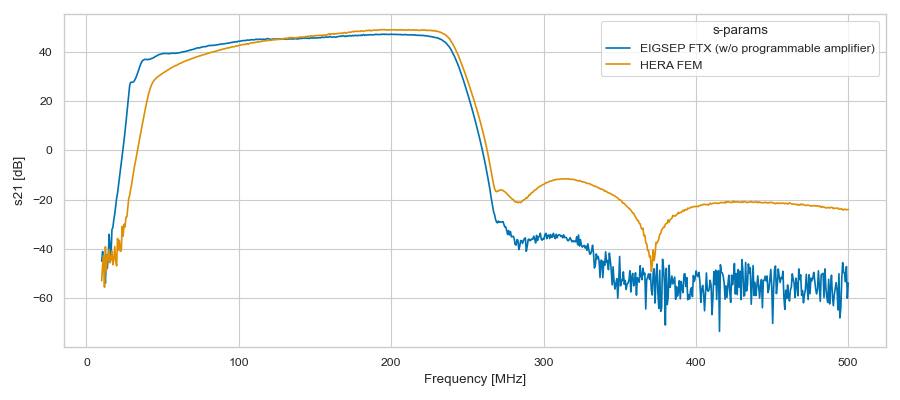

In [34]:
"""
Notes: 
------
EIGSEP FTX and HERA FEM setup:
• output power on FieldFox: -40 dBm
• 30dB fixed attenuation on FieldFox Port 1 output
• Avg: 100, • Num points: 801

During meeting, we noted EIGSEP FTX s21 "shelf" at 30-40 MHz, potential relfection.
a reflection. Next test we can add an additional 3dB attenuator after the filters."""


plt.figure(figsize=(9,4))
plt.plot(freq_, s_21, label="EIGSEP FTX (w/o programmable amplifier)")
plt.plot(freq__, s__21, label="HERA FEM")
plt.xlabel("Frequency [MHz]")
plt.ylabel("s21 [dB]")
plt.legend(title="s-params")
plt.tight_layout()
plt.show()

In [24]:
# ======== EIGSEP FTX ===========
dat10 = load_s2p_manual("/Users/rs_mbpro14/RAL/RFoF/june6_front_end_tests/AutoSave10.s2p")
s21_test10 = dat10["S21"]
s11_test10 = dat10["S11"]
s12_test10 = dat10["S12"]
s22_test10 = dat10["S22"]
freq_ = dat10["frequency"]

dat11 = load_s2p_manual("/Users/rs_mbpro14/RAL/RFoF/june6_front_end_tests/AutoSave11.s2p")
s21_test11 = dat11["S21"]
s11_test11 = dat11["S11"]
s12_test11 = dat11["S12"]
s22_test11 = dat11["S22"]
freq__ = dat11["frequency"]

dat12 = load_s2p_manual("/Users/rs_mbpro14/RAL/RFoF/june6_front_end_tests/AutoSave12.s2p")
s21_test12 = dat12["S21"]
s11_test12 = dat12["S11"]
s12_test12 = dat12["S12"]
s22_test12 = dat12["S22"]
freq__ = dat12["frequency"]

"""
Test 13
swapped places for the 3dB and 6dB attenuators
LNA-> -6dB -> filters -> -6 dB -> transmitter onboard amplifer -> -3dB -> sma cable -> -3dB -> optical input
"""
dat13 = load_s2p_manual("/Users/rs_mbpro14/RAL/RFoF/june6_front_end_tests/AutoSave13.s2p")
s21_test13 = dat13["S21"]
s11_test13 = dat13["S11"]
s12_test13 = dat13["S12"]
s22_test13 = dat13["S22"]
freq__ = dat12["frequency"]

dat14 = load_s2p_manual("/Users/rs_mbpro14/RAL/RFoF/june6_front_end_tests/AutoSave14.s2p")
s21_test14 = dat14["S21"]
s11_test14 = dat14["S11"]
s12_test14 = dat14["S12"]
s22_test14 = dat14["S22"]
freq__ = dat12["frequency"]

"""lna -> -6db attn -> filters -> -6db attn -> transmitter onboard amp -> -6db attn"""
dat15 = load_s2p_manual("/Users/rs_mbpro14/RAL/RFoF/june6_front_end_tests/AutoSave15.s2p")
s21_test15 = dat15["S21"]
s11_test15 = dat15["S11"]
s12_test15 = dat15["S12"]
s22_test15 = dat15["S22"]
freq__ = dat12["frequency"]

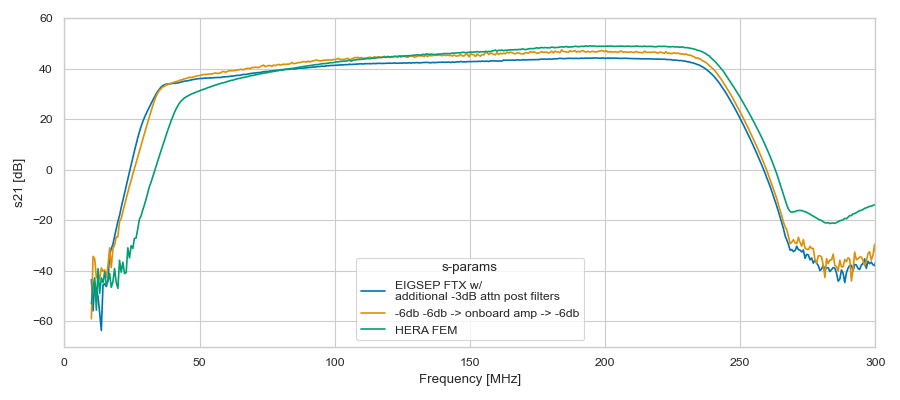

In [39]:
plt.figure(figsize=(9, 4))
plt.plot(freq_,  s21_test10, label="EIGSEP FTX w/ \nadditional -3dB attn post filters")
# plt.plot(freq__, s21_test11, label="EIGSEP FTX, onboard amp (+15dB) -3dB - 6dB attn")
# plt.plot(freq__, s21_test12, label="onboard amp -6dB -6dB")
# plt.plot(freq__, s21_test13, label="-6db -6db -> onboard amp -3dB -3dB")
# plt.plot(freq__, s21_test14, label="-6db -3db -3db -> onboard amp -3dB -3dB")
plt.plot(freq__, s21_test15, label="-6db -6db -> onboard amp -> -6db") # optimal
plt.xlabel("Frequency [MHz]")
plt.ylabel("s21 [dB]")

plt.plot(freq__, s__21, label="HERA FEM") 

plt.xlim(0, 300)
plt.ylim(-70, 60)

plt.legend(title="s-params")
plt.tight_layout()
plt.show()

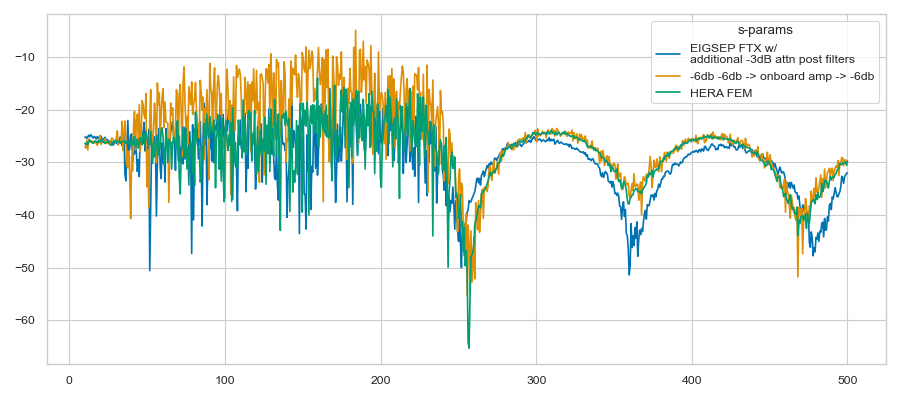

In [47]:
plt.figure(figsize=(9,4))
plt.plot(freq_, s11_test10, label="EIGSEP FTX w/ \nadditional -3dB attn post filters")
plt.plot(freq__, s11_test15, label="-6db -6db -> onboard amp -> -6db") # optimal
# plt.plot(freq__, s11_test12, label="onboard amp -6dB -6dB")
plt.plot(freq__, s__11, label="HERA FEM")

# plt.xlim(0, 300)
plt.legend(title="s-params")
plt.tight_layout()
plt.show()